<a href="https://colab.research.google.com/github/furibeguerra/PNL/blob/main/Desafio_4_Uribe_Guerra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [2]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [4]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [5]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 14.5MB/s]


In [7]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [8]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [10]:
# Objetivo 1: Observar como está distribuido el dataset respecto a la columna Rating

import plotly.express as px
rating_counts = df_reviews['Rating'].value_counts().sort_index().reset_index()
rating_counts.columns = ['Rating', 'Cantidad de Reseñas']

# Creamos el gráfico de barras interactivo con Plotly Express
fig = px.bar(rating_counts,
             x='Rating',
             y='Cantidad de Reseñas',
             title='Distribución de Ratings por Cantidad de Reseñas',
             labels={'Rating': 'Rating (0-4)',
                     'Cantidad de Reseñas': 'Número de Reseñas'},
             color='Cantidad de Reseñas',  # Opcional: colorear las barras por la cantidad
             color_continuous_scale='viridis') # Opcional: elegir una escala de colores

fig.show()

Al observar la distribución del dataset en relación con la columna '*Rating*', se identifica un desequilibrio significativo. Existe una mayor proporción de instancias con ratings altos (3 y 4), mientras que las categorías de ratings bajos (0, 1 y 2) presentan una representación menor Esta distribución, que no es uniforem, podría tener implicaciones relevantes al entrenar el modelo.

In [11]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
reviews = np.array(df_reviews['Review Text'])

In [12]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(reviews)

22641

In [16]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(reviews.astype(str))
print("Primeros 100 caracteres del corpus:")
print(corpus[:100])

Primeros 100 caracteres del corpus:
Absolutely wonderful - silky and sexy and comfortable Love this dress!  it's sooo pretty.  i happene


In [17]:
# Alumno: ¿Cuál es la longitud de ese corpus?
print("\nLongitud total del corpus:", len(corpus))


Longitud total del corpus: 7011643


In [18]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [19]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens = text_to_word_sequence(corpus)
print(tokens[:20])

['absolutely', 'wonderful', 'silky', 'and', 'sexy', 'and', 'comfortable', 'love', 'this', 'dress', "it's", 'sooo', 'pretty', 'i', 'happened', 'to', 'find', 'it', 'in', 'a']


In [20]:
# Alumno: ¿Cuántos tokens/palabras hay?
print("\n En total encontramos que la cantidad de tokens/palabras son:", len(tokens))


 En total encontramos que la cantidad de tokens/palabras son: 1372203


In [22]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
num_words = 5000
vocab_size = num_words

In [23]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_reviews['Review Text'])
word_index = tokenizer.word_index # Obtenemos el diccionario de palabra a índice
total_vocabulary_size = len(word_index) # Obtenemos el tamaño total del vocabulario encontrado


print("Diccionario de palabra a índice (word_index):")
print(dict(list(word_index.items())[:20]))

print("\nCantidad total del vocabulario encontrado:", total_vocabulary_size)

print("\nCantidad máxima de palabras a utilizar (num_words):", num_words)

if total_vocabulary_size > num_words:
    print(f"\nAdvertencia: El vocabulario real ({total_vocabulary_size}) es mayor que la cantidad máxima de palabras a utilizar ({num_words}). Esto significa que algunas palabras serán tratadas como '<unk>' (unknown) durante la tokenización.")
else:
    print("\nEl tamaño del vocabulario está dentro del límite especificado.")



Diccionario de palabra a índice (word_index):
{'the': 1, 'i': 2, 'and': 3, 'a': 4, 'it': 5, 'is': 6, 'this': 7, 'to': 8, 'in': 9, 'but': 10, 'on': 11, 'for': 12, 'of': 13, 'with': 14, 'was': 15, 'so': 16, 'my': 17, 'dress': 18, 'not': 19, 'that': 20}

Cantidad total del vocabulario encontrado: 14847

Cantidad máxima de palabras a utilizar (num_words): 5000

Advertencia: El vocabulario real (14847) es mayor que la cantidad máxima de palabras a utilizar (5000). Esto significa que algunas palabras serán tratadas como '<unk>' (unknown) durante la tokenización.


In [24]:
num_words = 15000 # Lo modificamos entonces para evitar que tengamos palabras en (unknown)
vocab_size = num_words

In [25]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_reviews['Review Text'])
word_index = tokenizer.word_index # Obtenemos el diccionario de palabra a índice
total_vocabulary_size = len(word_index) # Obtenemos el tamaño total del vocabulario (Cantidad de palabras unicas)


print("Diccionario de palabra a índice (word_index):")
print(dict(list(word_index.items())[:20]))

print("\nCantidad total del vocabulario encontrado:", total_vocabulary_size)

print("\nCantidad máxima de palabras a utilizar (num_words):", num_words)

if total_vocabulary_size > num_words:
    print(f"\nAdvertencia: El vocabulario real ({total_vocabulary_size}) es mayor que la cantidad máxima de palabras a utilizar ({num_words}). Esto significa que algunas palabras serán tratadas como '<unk>' (unknown) durante la tokenización.")
else:
    print("\nEl tamaño del vocabulario está dentro del límite especificado.")

Diccionario de palabra a índice (word_index):
{'the': 1, 'i': 2, 'and': 3, 'a': 4, 'it': 5, 'is': 6, 'this': 7, 'to': 8, 'in': 9, 'but': 10, 'on': 11, 'for': 12, 'of': 13, 'with': 14, 'was': 15, 'so': 16, 'my': 17, 'dress': 18, 'not': 19, 'that': 20}

Cantidad total del vocabulario encontrado: 14847

Cantidad máxima de palabras a utilizar (num_words): 15000

El tamaño del vocabulario está dentro del límite especificado.


In [33]:
print("Diccionario de palabra a índice (word_index):")
for word, index in list(word_index.items())[:40]:
    print(f"'{word}': {index}")

Diccionario de palabra a índice (word_index):
'the': 1
'i': 2
'and': 3
'a': 4
'it': 5
'is': 6
'this': 7
'to': 8
'in': 9
'but': 10
'on': 11
'for': 12
'of': 13
'with': 14
'was': 15
'so': 16
'my': 17
'dress': 18
'not': 19
'that': 20
'love': 21
'size': 22
'very': 23
'have': 24
'top': 25
'fit': 26
'are': 27
'like': 28
'be': 29
'as': 30
'me': 31
'wear': 32
'it's': 33
'great': 34
'too': 35
'i'm': 36
'or': 37
'am': 38
'just': 39
'you': 40


In [32]:
# Alumno: Convertir las palabras/tokens a números
sequences = tokenizer.texts_to_sequences(df_reviews['Review Text'])
print("Texto:", df_reviews['Review Text'].iloc[20])
print("Secuencia:", sequences[20])

Texto: If this product was in petite, i would get the petite. the regular is a little long on me but a tailor can do a simple fix on that. 

fits nicely! i'm 5'4, 130lb and pregnant so i bough t medium to grow into. 

the tie can be front or back so provides for some nice flexibility on form fitting.
Secuencia: [49, 7, 753, 15, 9, 95, 2, 41, 115, 1, 95, 1, 184, 6, 4, 53, 90, 11, 31, 10, 4, 1285, 66, 134, 4, 548, 1114, 11, 20, 67, 67, 78, 258, 36, 310, 3251, 3, 861, 16, 2, 3558, 307, 97, 8, 3142, 313, 67, 67, 1, 467, 66, 29, 156, 37, 63, 16, 1950, 12, 152, 70, 3559, 11, 624, 356]


In [34]:
# Alumno: Determinar cual es la oración más larga

# 1. Encontrar la reseña más larga basada en la cantidad de caracteres
reseña_mas_larga_por_caracteres = df_reviews['Review Text'].loc[df_reviews['Review Text'].str.len().idxmax()]
longitud_caracteres = len(reseña_mas_larga_por_caracteres)

print("Reseña más larga (por cantidad de caracteres):")
print(reseña_mas_larga_por_caracteres)
print("\nLongitud (en caracteres):", longitud_caracteres)

# 2. Encontrar la reseña más larga basada en la cantidad de palabras (aproximación por espacios)
reseña_mas_larga_por_palabras = df_reviews['Review Text'].loc[df_reviews['Review Text'].str.split().str.len().idxmax()]
cantidad_palabras = len(reseña_mas_larga_por_palabras.split())

print("\nReseña más larga (por cantidad de palabras):")
print(reseña_mas_larga_por_palabras)
print("\nCantidad de palabras (aproximada):", cantidad_palabras)

Reseña más larga (por cantidad de caracteres):
I adore this blouse. the colors are vibrant (see my photo below). this is one of my favorite purchases from retailer. the top is light weight. true to size. i ordered a petite small and am 5 feet tall 120 lbs. and curvy. i left it untucked and loose like in the photo and it was very flattering. i disagree about it being frumpy. i wore it with kelly green retailer brand slacks paired with the retailer yellow sweater coat with white piping, and the retailer moss suede cross bag and neutral color (nude) fl

Longitud (en caracteres): 508

Reseña más larga (por cantidad de palabras):
I love shift dresses and i love t linen so this one was a must for me. i had it in my inbox as soon as it came out on the website and then i found it in the store and had to try it on. i took the six and the eight to the fitting room because i run in between, and the six fit better so i guess it runs a little bit large. really it just depends on how you want it to 

In [35]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia (Para mi ejercicio entonces tomare por cantidad de palabras)
from tensorflow.keras.utils import pad_sequences
maxlen = 115 #Oración mas larga por cantidad de palabras

In [37]:
# Alumno: Observar las dimensiones de la variable input
padded_sequences = pad_sequences(sequences, maxlen=maxlen,padding='post', truncating='post')

#Usaremos padding='post' para añadir los valores de relleno (generalmente ceros) al final de las secuencias más cortas.
#Usaremos truncating='post' indica que si una secuencia excede la longitud máxima, los elementos se eliminarán desde el final.

input = padded_sequences
dimensiones_input = input.shape # dimensiones de la variable 'input'

print("Dimensiones de la variable 'input':", dimensiones_input)

Dimensiones de la variable 'input': (22641, 115)


In [40]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir  (en este ejemplo son 5)


# 1. Seleccionar la columna 'Rating' y almacenarla en 'y'
y = df_reviews['Rating']
# 2. Aplicar one-hot encoding usando to_categorical
num_classes = 5  # (en este ejemplo son 5)
y = to_categorical(y, num_classes=num_classes)

# Verificamos la shape de la variable
print("Shape de la variable 'y':", y.shape)

print("\nPrimeras 5 filas de 'y' (one-hot encoding):")
print(y[:5])

print("\nCantidad de filas de df_reviews:", len(df_reviews))




Shape de la variable 'y': (22641, 5)

Primeras 5 filas de 'y' (one-hot encoding):
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]

Cantidad de filas de df_reviews: 22641


In [41]:
y_labels = np.argmax(y, axis=1)

unique, counts = np.unique(y_labels, return_counts=True)

for cls, count in zip(unique, counts):
    print(f"Clase {cls}: {count} ejemplos")


Clase 0: 821 ejemplos
Clase 1: 1549 ejemplos
Clase 2: 2823 ejemplos
Clase 3: 4908 ejemplos
Clase 4: 12540 ejemplos


In [43]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X = padded_sequences
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [50]:
# Alumno: determinar la dimensiones de entrada y salida
print("\nDimensiones de entrada (X):", X.shape[1]) #Long maxima de oracion por palabras
print("\nDimensiones de salida (y):", y.shape[1]) #Clases



Dimensiones de entrada (X): 115

Dimensiones de salida (y): 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [51]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Embedding, Dropout, Masking, Bidirectional,GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [53]:
y_train_labels = np.argmax(y_train, axis=1)
weights = class_weight.compute_class_weight(class_weight='balanced',
                                             classes=np.unique(y_train_labels),
                                             y=y_train_labels)
class_weights = dict(enumerate(weights))

In [54]:
print(class_weights)

{0: np.float64(5.382466567607727), 1: np.float64(2.9212903225806452), 2: np.float64(1.6207606263982104), 3: np.float64(0.9126732174351222), 4: np.float64(0.36242121060530263)}


In [55]:
input_length = x_train.shape[1]
output_dim = y.shape[1]

# **Sin embeddings pre entrenados**

In [59]:
output_dim = y.shape[1]
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=128, input_length=maxlen, mask_zero=True))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(output_dim, activation='softmax'))

In [62]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [64]:
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=10,
                    batch_size=64,
                    class_weight=class_weights)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning:

Layer 'global_max_pooling1d_1' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.



283/283 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.3198 - loss: 1.5090 - val_accuracy: 0.5820 - val_loss: 1.0214
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5525 - loss: 1.1750 - val_accuracy: 0.5968 - val_loss: 0.9609
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6327 - loss: 0.9775 - val_accuracy: 0.6189 - val_loss: 0.9015
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.6635 - loss: 0.8896 - val_accuracy: 0.5992 - val_loss: 0.9589
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.7114 - loss: 0.7341 - val_accuracy: 0.5736 - val_loss: 1.0294
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7388 - loss: 0.6429 - val_accuracy: 0.6041 - val_loss: 1.1408
Epoch 7/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7715 - loss: 0.5444 - val_accuracy: 0.5986 - val_loss: 1.3169
Epoch 8/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7881 - loss: 0.4710 - val_accuracy: 0.

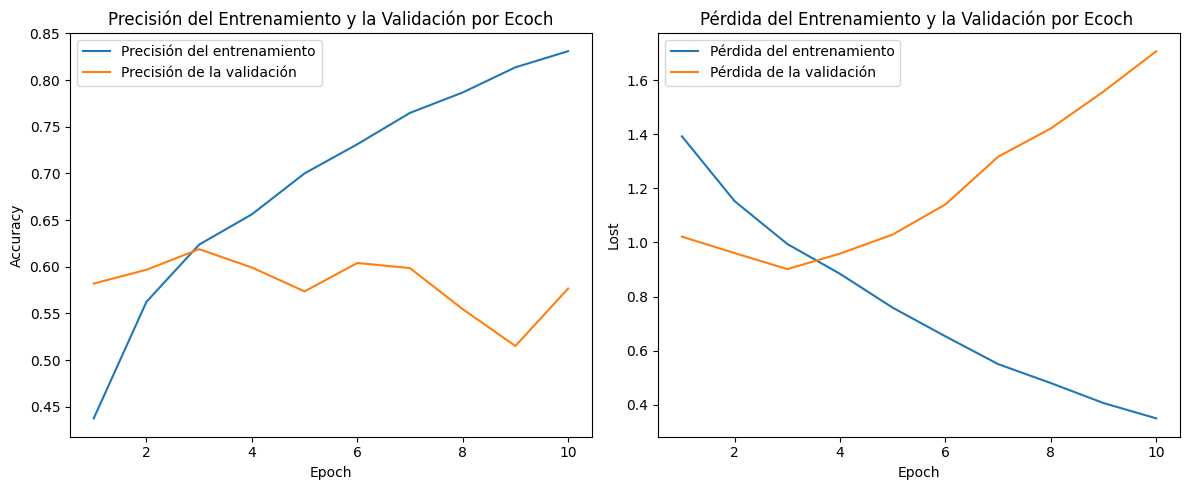

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_learning_curves(history):

    # Graficar la precisión
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.lineplot(x=range(1, len(history.history['accuracy']) + 1),
                 y=history.history['accuracy'],
                 label='Precisión del entrenamiento')
    sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1),
                 y=history.history['val_accuracy'],
                 label='Precisión de la validación')
    plt.title('Precisión del Entrenamiento y la Validación por Ecoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Graficar la pérdida
    plt.subplot(1, 2, 2)
    sns.lineplot(x=range(1, len(history.history['loss']) + 1),
                 y=history.history['loss'],
                 label='Pérdida del entrenamiento')
    sns.lineplot(x=range(1, len(history.history['val_loss']) + 1),
                 y=history.history['val_loss'],
                 label='Pérdida de la validación')
    plt.title('Pérdida del Entrenamiento y la Validación por Ecoch ')
    plt.xlabel('Epoch')
    plt.ylabel('Lost')
    plt.legend()

    plt.tight_layout()
    plt.show()

if 'history' in locals():
    plot_learning_curves(history)
else:
    print("Por favor, ejecuta el entrenamiento del modelo primero para obtener el 'history'.")

In [70]:
#Aumentemos las epocas a 100
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=100,
                    batch_size=64,
                    class_weight=class_weights)

Epoch 1/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8556 - loss: 0.2955 - val_accuracy: 0.5147 - val_loss: 1.8802
Epoch 2/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8625 - loss: 0.2654 - val_accuracy: 0.5633 - val_loss: 2.0606
Epoch 3/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.8833 - loss: 0.2378 - val_accuracy: 0.5418 - val_loss: 2.2019
Epoch 4/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8921 - loss: 0.2166 - val_accuracy: 0.5637 - val_loss: 2.2156
Epoch 5/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.9040 - loss: 0.1733 - val_accuracy: 0.5390 - val_loss: 2.5288
Epoch 6/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9154 - loss: 0.1701 - val_accuracy: 0.5527 - val_loss: 2.6231
Epoch 7/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9267 - loss: 0.1444 - val_accuracy: 0.5604 - val_loss: 2.7503
Epoch 8/100
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9243 - loss: 0.1614 

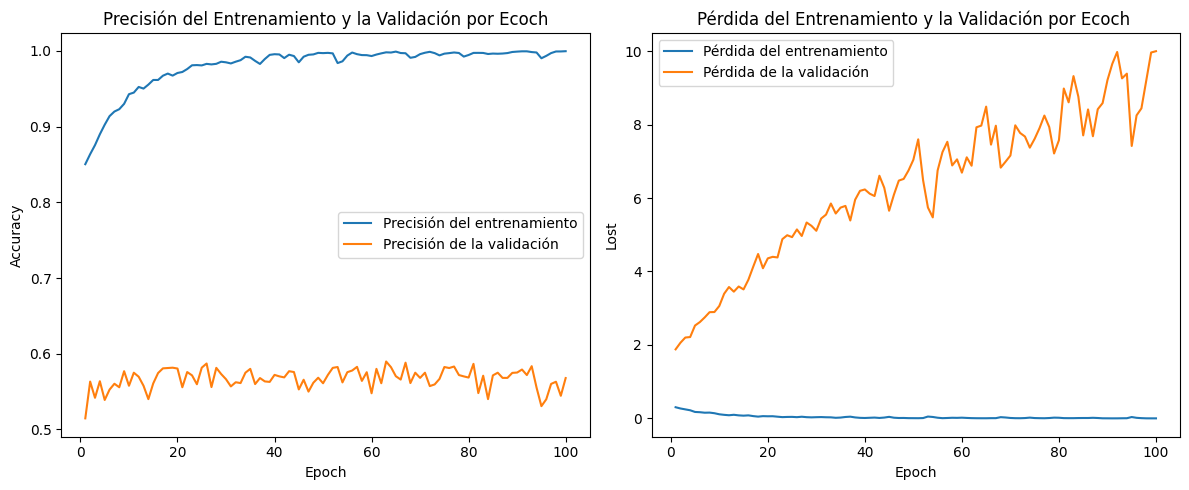

In [71]:
plot_learning_curves(history)

# Con Embedings Preentrenados

**Con embeddings pre entrenados**

In [80]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("danielwillgeorge/glove6b100dtxt")

print("Path to dataset files:", path)



Path to dataset files: /kaggle/input/glove6b100dtxt


In [97]:
import numpy as np

embedding_index = {}
glove_file_path = '/content/glove.6B.100d.txt'

try:
    with open(glove_file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = vector
    print(f"Loaded {len(embedding_index)} word vectors from {glove_file_path}")
except FileNotFoundError:
    print(f"Error: GloVe file not found at {glove_file_path}. Please ensure the file is uploaded to this location in Colab.")
    embedding_index = {}
except Exception as e:
    print(f"Error reading GloVe file: {e}")
    embedding_index = {}


Error reading GloVe file: could not convert string to float: '-'


In [98]:
embedding_dim = 10
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [99]:
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim,
                     weights=[embedding_matrix],
                     trainable=False))

model2.add(Bidirectional(LSTM(128, return_sequences=True)))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(output_dim, activation='softmax'))


In [100]:
model2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [101]:
history_pre_trained = model2.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=10,
                    batch_size=64,
                    class_weight=class_weights)

Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.1866 - loss: 1.6073 - val_accuracy: 0.5619 - val_loss: 1.6083
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.1515 - loss: 1.6243 - val_accuracy: 0.5619 - val_loss: 1.6087
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.3093 - loss: 1.5978 - val_accuracy: 0.0327 - val_loss: 1.6101
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.0481 - loss: 1.6211 - val_accuracy: 0.2073 - val_loss: 1.6085
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.1211 - loss: 1.6401 - val_accuracy: 0.5619 - val_loss: 1.6071
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.2775 - loss: 1.6082 - val_accuracy: 0.0682 - val_loss: 1.6097
Epoch 7/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1908 - loss: 1.6152 - val_accuracy: 0.0682 - val_loss: 1.6114
Epoch 8/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.1980 - loss: 1.6030 - val_acc

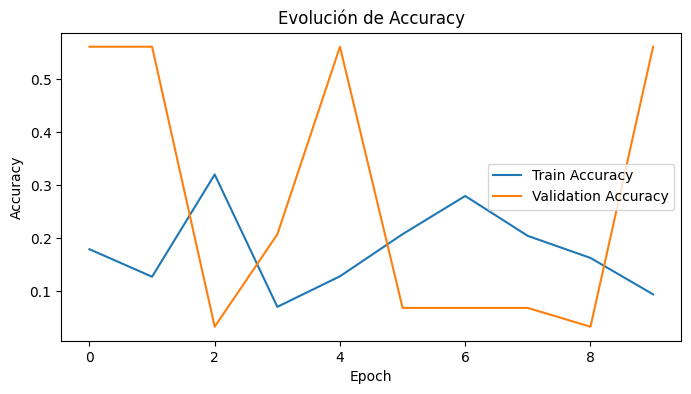

In [102]:
plt.figure(figsize=(8,4))
plt.plot(history_pre_trained.history['accuracy'], label='Train Accuracy')
plt.plot(history_pre_trained.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolución de Accuracy')
plt.legend()
plt.show()